In [1]:
!pip install langchain_community
!pip install replicate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 1.8 MB/s eta 0:00:00


In [2]:
from langchain_community.llms import Replicate
from google.colab import userdata
import os
import pandas as pd
from tqdm import tqdm

# Ambil token dari colab
api_token = userdata.get("api_token")

# Masukin token ke env variable
os.environ["REPLICATE_API_TOKEN"] = api_token

In [3]:
parameters = {
  "top_k": 5,
  "top_p": 1.0,
  "max_tokens": 4096,
  "min_tokens": 0,
  "random_seed": None,
  "repetition_penalty": 1.0,
  "temperature": 0.7,
  "stopping_criteria": "length (256 tokens)",
  "stopping_sequence": None
}

# Define LLM
llm = Replicate(
    model="ibm-granite/granite-3.3-8b-instruct",
    input=parameters
)

In [5]:
# Load dataset
df = pd.read_csv("news.csv")

print(df.columns)
df = df[['title', 'description']].dropna().head(100)

df.head(100)


Index(['title', 'pubDate', 'guid', 'link', 'description'], dtype='object')


,title,description
0,Ukraine: Angry Zelensky vows to punish Russian...,The Ukrainian president says the country will ...
1,War in Ukraine: Taking cover in a town under a...,"Jeremy Bowen was on the frontline in Irpin, as..."
2,Ukraine war 'catastrophic for global food',One of the world's biggest fertiliser firms sa...
3,Manchester Arena bombing: Saffie Roussos's par...,The parents of the Manchester Arena bombing's ...
4,Ukraine conflict: Oil price soars to highest l...,Consumers are feeling the impact of higher ene...
...,...,...
95,Ukraine maps: Ukraine says Russian ceasefire o...,Russia says it will offer civilians an evacuat...
96,How many refugees have fled Ukraine and where ...,The UN says four million people may try to esc...
97,Five ways the Ukraine war could push up prices,Prices for everyday items could go up at a tim...
98,Ukraine: Irish student makes fresh escape attempt,A 19-year-old Irish woman living in Sumy is tr...


In [6]:
# Fungsi untuk membuat prompt berdasarkan baris berita
def make_prompt(title, description):
    return f"""
Classify the following news into one of the following categories without any additional explanation:
- politics
- sports
- economy
- health
- technology
- entertainment

Title: {title}
Description: {description}

Category:
"""


In [7]:
# Simpan hasil prediksi
predictions = []

# Gunakan tqdm untuk progres bar
for i, row in tqdm(df.iterrows(), total=len(df)):
    prompt = make_prompt(row['title'], row['description'])
    try:
        response = llm.invoke(prompt)
        predictions.append(response.strip().lower())
    except Exception as e:
        predictions.append("error")
        print(f"Error at index {i}: {e}")

# Tambahkan hasil prediksi ke dataframe
df['predicted_category'] = predictions

100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


In [10]:
# Lihat hasil klasifikasi
df[['title', 'description', 'predicted_category']].head(100)

,title,description,predicted_category
0,Ukraine: Angry Zelensky vows to punish Russian...,The Ukrainian president says the country will ...,politics
1,War in Ukraine: Taking cover in a town under a...,"Jeremy Bowen was on the frontline in Irpin, as...",politics
2,Ukraine war 'catastrophic for global food',One of the world's biggest fertiliser firms sa...,politics (due to the geopolitical nature of th...
3,Manchester Arena bombing: Saffie Roussos's par...,The parents of the Manchester Arena bombing's ...,"the news falls under the category of ""tragedy/..."
4,Ukraine conflict: Oil price soars to highest l...,Consumers are feeling the impact of higher ene...,economy
...,...,...,...
95,Ukraine maps: Ukraine says Russian ceasefire o...,Russia says it will offer civilians an evacuat...,politics
96,How many refugees have fled Ukraine and where ...,The UN says four million people may try to esc...,politics\n\ncategory: politics\n\nexplanation:...
97,Five ways the Ukraine war could push up prices,Prices for everyday items could go up at a tim...,economy
98,Ukraine: Irish student makes fresh escape attempt,A 19-year-old Irish woman living in Sumy is tr...,politics (this news involves geopolitical tens...


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [16]:
# Fungsi untuk mengambil kategori pertama yang muncul
def extract_category(text):
    match = re.search(r'\b(politics|sports|economy|technology|entertainment|health)\b', text.lower())
    return match.group(0) if match else "unknown"

# Terapkan ke kolom predicted_category
df['clean_category'] = df['predicted_category'].apply(extract_category)

/tmp/ipython-input-17-2083717280.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='clean_category', order=df['clean_category'].value_counts().index, palette='Set2')


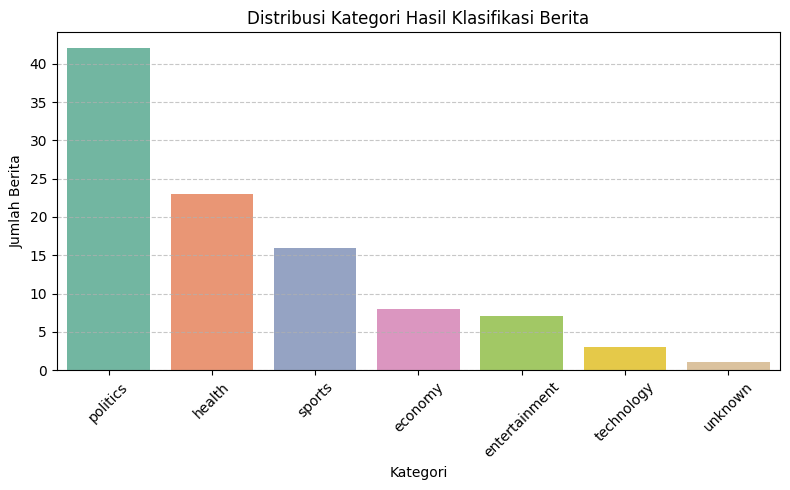

In [17]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='clean_category', order=df['clean_category'].value_counts().index, palette='Set2')

plt.title("Distribusi Kategori Hasil Klasifikasi Berita")
plt.xlabel("Kategori")
plt.ylabel("Jumlah Berita")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [13]:
# Buat input untuk analisis
analysis_input = ""
for i, row in df.iterrows():
    analysis_input += f"- Title: {row['title']}\n  Description: {row['description']}\n  Predicted Category: {row['predicted_category']}\n\n"

# Buat prompt untuk insight & rekomendasi
analysis_prompt = f"""
You are an expert data analyst. Below is a collection of classified news articles with their predicted categories.

Please analyze the data and provide:
1. Insight & Findings: Insights are analyzed, unique, and written with a logical and thorough explanation.
2. Recommendations: Recommendations are insightful, concrete, actionable, and have a real impact on the problem.

Here is the data:

{analysis_input}

Your response should be clearly separated into:
- Insight & Findings
- Recommendations
"""

In [14]:
# Jalankan analisis dengan LLM
try:
    analysis_result = llm.invoke(analysis_prompt)
    print("\n=== ANALYSIS RESULT ===\n")
    print(analysis_result)
except Exception as e:
    print(f"Error during analysis: {e}")


=== ANALYSIS RESULT ===

## Insight & Findings

### Politics
1. **Geopolitical Tensions and Conflict**: The articles consistently highlight the political nature of the Ukraine conflict, with discussions centered around international relations, government actions, and the geopolitical implications of the war. The predicted categories for news related to Ukraine, such as "Chaos and tears as thousands try to catch a train out of Ukraine," "Ukraine maps: Ukraine says Russian ceasefire offer 'immoral'," and "How many refugees have fled Ukraine and where are they going?", clearly indicate a political lens through which the events are viewed.
   
2. **Impact on International Relations**: The articles underscore how the war affects global politics, including diplomatic relations, international sanctions, and geopolitical strategies of various world leaders. The involvement of multiple countries' leaders in discussions about sanctions and refugee policies reflects the political dimension of th